In [1]:
def show_state(env, step=0, name="", info=""):
    """Fn to visualize the agent playing the game in a notebook
    """
    plt.figure(10)
    plt.clf()
    im = env.render(mode="rgb_array")
    plt.imshow(im[0])
    plt.title("{} | Step: {} {}".format(name, step, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [2]:
import torch
from scipy import optimize
import torch.nn.functional as F
import math
import numpy as np
from functools import reduce
from collections import OrderedDict
import matplotlib.pyplot as plt
from IPython import display
from optimization.Optimizer import PyTorchObjective

In [3]:
import logging
# logging.basicConfig(level='DEBUG')

In [4]:
import gym

In [5]:
import gvgai

In [6]:
# import matplotlib.pyplot as plt


In [7]:
from generator.levels.base import Generator

In [8]:
import numpy as np

In [9]:
from agent.NNagent import NNagent

In [10]:
from generator.env_gen_wrapper import GridGame

In [11]:
from scipy.optimize import Bounds

In [12]:
_x = NNagent(GridGame(game='dzelda', 
                      play_length=1000, 
                      path='./levels',
                      lvl_name='step1.txt',
                      mechanics=['1', '2', '3', '+', 'g', 'w'], # monsters, key, door, wall
                      images=True,
                  )
         )

In [13]:
print(str(_x.env.generator))

wwwwwwwwwwwww
w...........w
w...........w
w.+.........w
w.....A.....w
w...........w
w...........w
w.g.........w
wwwwwwwwwwwww



In [ ]:
_x.nn = torch.load("./25_gen_weights_5_5.pt")
# _x.nn = torch.load("./1_monster_weights_5_5.pt")
# _x.nn = torch.load("./dzelda_1_monster_weights_250.pt")

In [ ]:
_x.nn

In [ ]:
_x.env.depth

In [ ]:
z = PyTorchObjective(_x)
# z = PyTorchObjective(_x)

In [ ]:
z.fun(z.x0)

In [ ]:
z.x0.shape


In [ ]:
bounds = [(-5, 5)]*z.x0.shape[0]

In [ ]:
from utils.diff_evo import differential_evolution

In [ ]:
import time

In [ ]:
# NOTE: positive values being shown as the acheived score is BAD! 
# We're trying to minimize the loss surface. 

In [ ]:
start = time.time()
ans = differential_evolution(z.fun, bounds, 
                             strategy='rand1bin',
                             popsize=99, 
                             maxiter=250,
                             polish=False, 
                             x0=z.x0)

In [ ]:
end = time.time() - start

In [ ]:
print(end//3600)

In [ ]:
ans

In [ ]:
z.x0 = ans.x

In [ ]:
state_dict = z.unpack_parameters(ans.x)
z.f.load_state_dict(state_dict)

In [ ]:
z.f == _x.nn

In [ ]:
# t = _x.env.reset()

In [ ]:
def move(action):
    a, b, c, d = _x.env.step(action)
    im = d['pic']
    return im, b

In [ ]:
# im, r = move(5)

In [ ]:
# plt.imshow(im)

In [ ]:
# r

In [15]:
_w = _x.mutate(1)

In [17]:
print(str(_w.env.generator))

wwwwwwwwwwwww
w...........w
w...........w
w.+.........w
w1....A.....w
w...........w
w...........w
w.g.........w
wwwwwwwwwwwww



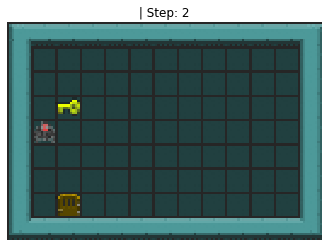

-1.0


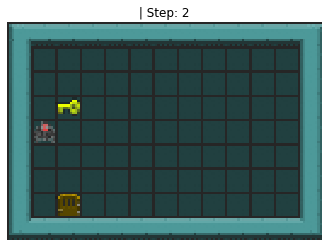

In [18]:
s = _x.fitness(fn=show_state) if _x.env.pics else _x.fitness()
_x.vis=None
print(s)

In [ ]:
2600 * 1000 * 100 # frames seen

In [ ]:
torch.save(_x.nn, "./dzelda_shifted_agent_250.pt")

```

First: Train an agent on an extremely simple level to give the agent a behavior starting point. 
    - In POET that was a flat terrain. In my case, it's a level that looks like this: 
    -   wwwwwwwwwwwww    
        w...........w    A --> agent
        w...........w    + --> key
        w.+....A....w    g --> goal
        w...........w
        w...........w    Task: Take the key to the goal
        w...........w
        w.g.........w
        wwwwwwwwwwwww
        
Second: Initialize agent-environment population with the first learned behavior
    
While True:
    
    Evaluate each agent in it's paired environment
    
    Mutate environments (every m loops). 
    
        Mutation of an environment causes the agent neural network to be copied into the new environment
        This increases the population.
        
        - An example mutation could be
            - adding/removing in an enemy (three types)
            - adding/moving a goal
            - adding/removing a key
            - moving an agent
            - An example new level could look like this: 
                - wwwwwwwwwwwww    
                  w....+..1...w    A --> agent
                  w...g.......w    + --> key
                  w...........w    g --> goal
                  w...........w
                  w...w.......w    Task: Take the key to the goal
                  w.......A...w
                  w.g.........w
                  wwwwwwwwwwwww

    (slowly) Run one step of optimization for each agent within it's paired environment.
    
    Transfer agents between environments (every k loops)
        Intuition: Agent alpha might have learned behavior in it's paired environment that is actually behavior that is very good in environment beta. 
        
        - test every agent in every environment. 
        - transfer into environment i, the agent j, who performed the best.
    
    Return to top of the loop.
    
```

# Note. 

Moving the key from top right corner to mid left created a slightly simpler env.

----  

we were not able to learn the good policy if we kept the wieght range as [-2, 2]. 

Next I am retrying the same starting point but with range [-5, 5]. --> solved extremely simple env with this range and simpler env. 



----  
Then moving the key up one spot meant that the agent needs more training. So far it has failed to take the key and get to the goal after an additional 20 generations of training (but does get the key). I am giving it another 20 generations. 

After the agent learns the new environment (key moved up one spot), I am going to take those weights and put them back into the first env (key moved back down one spot).

----  
Note: There are times that the optimization straight up fails after only a generation or two. I think this is coming from the fact that the problem is very sparely rewarded.   

----

Edited dzelda.txt: 
    - picking up key +1
    - killing monster +1
    - taking key to door +2


1)  
```
wwwwwwwwwwwww
w...........w
w...........w
w.+....A....w
w...........w
w...........w
w...........w
w.g.........w
wwwwwwwwwwwww
```
2)   
```
wwwwwwwwwwwww
w...........w
w...........w
w.+.........w
w......A....w
w...........w
w...........w
w.g.........w
wwwwwwwwwwwww
```

3)  
```
wwwwwwwwwwwww
w...........w
w...........w
w.+.........w
w......A....w
w...........w
w..1........w
w.g.........w
wwwwwwwwwwwww
```

4)  
```
wwwwwwwwwwwww
w...........w
w...........w
w.+.w.......w
w...w..A....w
w...........w
w..1........w
w.g.........w
wwwwwwwwwwwww
```